In [14]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")

U2 (generic function with 1 method)

In [15]:
using LinearAlgebra, Optim, Measures, CSV, DataFrames,Plots

In [64]:
ω_c = 5000
ω_q = 3000
χ = 3e-1
N = 8
amp_c = 1
amp_q = 1
T = 2

2

### Target gate

In [65]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
#X_gate = kron(x_gate(N, Array[[3,4], [5,6], [7,8]]), I_qubit)
#X_gate = kron(x_gate(N, Array[[1,2]]), I_qubit)
X_gate = kron(x_gate(N, Array[[3,4]]), I_qubit)

θ = π/2.5
RZ = kron(Rz(N, Array[[1,3]], θ), I_qubit)
RX = kron(Rx(N, Array[[3,4]], θ/4), I_qubit)
Udue = kron(U2(N, Array[[3,4]], [θ/2 θ/3 θ/4] ), I_qubit)

sx = kron(I_cavity, [0 1; 1 0])
sy = kron(I_cavity, [0 -1im; 1im 0])
# generating matrices
a,adag,sp,sm,sz = generate_matrices(N)

ψ_initial = zeros(N)
ψ_initial[1] = 1
ψ_initial = kron(ψ_initial/norm(ψ_initial), [0,1])

interaction_transformation(t) = cis(- (ω_c * a' * a + ω_q / 2 * sz) * t)
int_transformation = interaction_transformation(T)

16×16 Matrix{ComplexF64}:
 -0.975682-0.21919im        0.0+0.0im      …        0.0+0.0im
       0.0+0.0im      -0.975682+0.21919im           0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im      …        0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im      …        0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im               0.0+0.0im
       0.0+0.0im            0.0+0.0im      …

In [66]:
H_drift = χ * adag * a * sz / 2 #+ ω_c * adag * a + ω_q * sz / 2

16×16 Matrix{Float64}:
 0.0  0.0  0.0    0.0   0.0   0.0  …  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.15   0.0   0.0   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0   -0.15  0.0   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.3   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0  -0.3  …  0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0     0.0    0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0  …  0.75   0.0   0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0     0.0   -0.75  0.0   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0   0.0     0.0    0.0   0.9   0.0  0.0    0.0
 0.0  0.0  0.0    0.0   0.0 

In [67]:
function cost_from_0_dispersive(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, initial_state, final_state, amp_q=1e-1, amp_c=1e-1)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = final_state' * propagator * initial_state
   
    return 1 - norm(c)^2
end

function cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = tr(unitary' * int_transformation * propagator)/dim
   
    return 1 - norm(c)^2
end

function cost_from_0_dispersive_gate_non_interaction(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = tr(unitary' * propagator)/dim
   
    return 1 - norm(c)^2
end

function propagator(H_drift, sp, sm, a, adag, T, δt, coefficients)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)

    amplitude_c = [ChebyshevT(coefficients[1:Int(length(coefficients)/2)])((2t - T)/T) for t in 0:δt:T]
    amplitude_q = [ChebyshevT(coefficients[Int(length(coefficients)/2) + 1:end])((2t - T)/T) for t in 0:δt:T]


    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for n in 1:1:Int(T/δt)+1
        H = H_drift + (amplitude_q(n) * sp + amplitude_q(n)' * sm) + (amplitude_c(n) * a + amplitude_c(n)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    return propagator * exp(-1im*angle(propagator[8, 8]))
    
end

function gradient(coefficients, unitary, N, h, cost_before_increment,cost)

    L = length(coefficients)
    gradient = zeros(L)

    for i in 1:L
        coeffs_copy = copy(coefficients)
        coeffs_copy[i] = coefficients[i] + h
        gradient[i] = (cost(coeffs_copy) - cost_before_increment) / h
    end

    return gradient

end

gradient (generic function with 2 methods)

In [68]:
snap(x) = kron(Diagonal(exp.(-1im.*x)),I_qubit)
snap_params = rand(N) * 2 * pi .- pi
SNAP_GATE = snap(snap_params)

16×16 Matrix{ComplexF64}:
 -0.0954692-0.995432im        -0.0-0.0im       …       0.0+0.0im
       -0.0-0.0im       -0.0954692-0.995432im          0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im       …       0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im       …       0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0+0.0im
        0.0+0.0im              0.0+0.0im               0.0-0.0im

In [34]:
f(x) = cost_from_0_dispersive(H_drift, sp, sm, a, adag, T, T / (10 * 3) , x, X_gate, ω_c, ω_q, ψ_initial, ψ_final_x)
g(x) = cost_from_0_dispersive_gate_non_interaction(H_drift, sp, sm, a, adag, T, T/50, x, X_gate, ω_c, ω_q, 1, 1)
r(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, RX, ω_c, ω_q, 1, 1)
s(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, SNAP_GATE, ω_c, ω_q, 1, 1)

s (generic function with 1 method)

In [ ]:
for i in 1:1
    println("iteration number: ", i )
    rand_coeffs_20 = rand(16)*2 .-1 + (rand(16)*2im .-1im)
    res_LBFGS = Optim.optimize(g, rand_coeffs_20 , LBFGS(), Optim.Options(show_trace=true, show_every=5, iterations=100))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    rand_coeffs_20 = zeros(4) + (zeros(4)*im)
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:8]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[9:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:12]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[13:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:16]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[17:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:20]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[21:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=300))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
end

In [69]:
x(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, X_gate, ω_c, ω_q, 10, 10)
r(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, RX, ω_c, ω_q, 10, 10)

it_costs_x = []
coefficients_x = []
it_costs_rx = []
coefficients_rx = []
for iteration in 1:1
    coefficients = rand(100)*2 .-1 + (rand(100)*2im .-1im)
    println(" iterations :", iteration)
    res_x = Optim.optimize(x, coefficients , LBFGS(), Optim.Options(show_trace=true, show_every=5, iterations=500))
    #res_rx = Optim.optimize(r, coefficients , LBFGS(), Optim.Options(iterations=2000))
    push!(it_costs_x,Optim.minimum(res_x))
    #push!(it_costs_rx,Optim.minimum(res_rx))
    push!(coefficients_x,Optim.minimizer(res_x))
    #push!(coefficients_rx,Optim.minimizer(res_rx))
end

 iterations :1
Iter     Function value   Gradient norm 


     0     9.996353e-01     3.642001e-02
 * time: 0.00012922286987304688


     5     7.912525e-01     1.045018e+00
 * time: 29.483644008636475


    10     6.327667e-01     8.419301e-01
 * time: 45.563523054122925


    15     4.815669e-01     1.200037e+00
 * time: 61.86174416542053


    20     3.246666e-01     5.398710e-01
 * time: 78.77959299087524


    25     2.358811e-01     9.245405e-01
 * time: 94.58346819877625


    30     1.751508e-01     7.952067e-01
 * time: 111.07732701301575


    35     1.270276e-01     3.725981e-01
 * time: 128.1419072151184


    40     1.045990e-01     5.370762e-01
 * time: 143.97481417655945


    45     8.551525e-02     3.073393e-01
 * time: 160.71158504486084


    50     6.290945e-02     3.035591e-01
 * time: 177.2907600402832


    55     4.685998e-02     2.351418e-01
 * time: 194.17695808410645


    60     3.529486e-02     2.320819e-01
 * time: 213.4889531135559


    65     3.034030e-02     1.115077e-01
 * time: 231.82780814170837


    70     2.604482e-02     1.688840e-01
 * time: 249.10456609725952


    75     2.301613e-02     1.461577e-01
 * time: 278.3303201198578


    80     1.989549e-02     9.242989e-02
 * time: 296.9852521419525


    85     1.723089e-02     1.589069e-01
 * time: 317.6803970336914


    90     1.513585e-02     2.053736e-01
 * time: 339.92502903938293


    95     1.380368e-02     1.054794e-01
 * time: 360.3208990097046


   100     1.260647e-02     7.310343e-02
 * time: 387.4644720554352


   105     1.131861e-02     6.608463e-02
 * time: 407.0721549987793


   110     1.018735e-02     6.935103e-02
 * time: 424.0825140476227


   115     9.207716e-03     1.002047e-01
 * time: 441.1597681045532


   120     8.146373e-03     1.584386e-01
 * time: 457.0343282222748


   125     7.368929e-03     5.728509e-02
 * time: 474.11239409446716


   130     6.699585e-03     7.538715e-02
 * time: 491.08517718315125


   135     6.328540e-03     3.619901e-02
 * time: 506.9849920272827


   140     5.909525e-03     3.883457e-02
 * time: 523.9732341766357


   145     5.462582e-03     4.048868e-02
 * time: 542.1280930042267


   150     5.181924e-03     8.623796e-02
 * time: 558.0854380130768


   155     4.845376e-03     3.565588e-02
 * time: 574.0614771842957


   160     4.558177e-03     5.323705e-02
 * time: 592.2297620773315


   165     4.346334e-03     2.947309e-02
 * time: 609.3462841510773


   170     4.137429e-03     2.395096e-02
 * time: 626.4221110343933


   175     3.902203e-03     4.031311e-02
 * time: 643.5036611557007


   180     3.704277e-03     3.417905e-02
 * time: 663.8594851493835


   185     3.523938e-03     5.887444e-02
 * time: 686.0354850292206


   190     3.334157e-03     4.115051e-02
 * time: 705.7078120708466


   195     3.143629e-03     3.103906e-02
 * time: 725.4415140151978


   200     3.021483e-03     6.117883e-02
 * time: 743.9500110149384


   205     2.892881e-03     3.016089e-02
 * time: 761.1270790100098


   210     2.757694e-03     2.249269e-02
 * time: 779.47572016716


   215     2.664555e-03     1.255432e-02
 * time: 797.9986770153046


   220     2.612811e-03     1.695552e-02
 * time: 816.3379080295563


   225     2.569772e-03     1.658958e-02
 * time: 833.611533164978


   230     2.516650e-03     1.994797e-02
 * time: 853.3317241668701


   235     2.484448e-03     1.083681e-02
 * time: 871.9333431720734


   240     2.444106e-03     1.644665e-02
 * time: 890.9464139938354


   245     2.397732e-03     1.559209e-02
 * time: 908.4052851200104


   250     2.358509e-03     1.103385e-02
 * time: 925.9236240386963


   255     2.328306e-03     1.560611e-02
 * time: 945.531327009201


   260     2.290290e-03     4.060482e-02
 * time: 966.1947450637817


   265     2.243699e-03     1.516615e-02
 * time: 986.2301061153412


   270     2.208965e-03     1.077578e-02
 * time: 1005.801351070404


   275     2.183129e-03     8.535145e-03
 * time: 1025.0124130249023


   280     2.155473e-03     1.210397e-02
 * time: 1045.5488481521606


   285     2.131111e-03     1.120820e-02
 * time: 1064.727280139923


   290     2.101889e-03     1.933355e-02
 * time: 1083.9882051944733


   295     2.078308e-03     1.823049e-02
 * time: 1101.1309320926666


   300     2.043296e-03     9.426932e-03
 * time: 1121.580782175064


   305     2.011649e-03     2.164888e-02
 * time: 1141.493535041809


   310     2.000847e-03     1.141688e-02
 * time: 1159.0931811332703


   315     1.987325e-03     1.091289e-02
 * time: 1178.1590650081635


   320     1.977010e-03     7.690508e-03
 * time: 1194.7572350502014


   325     1.959350e-03     1.255659e-02
 * time: 1214.2975850105286


   330     1.946767e-03     1.413013e-02
 * time: 1231.3544631004333


   335     1.934889e-03     1.053577e-02
 * time: 1248.497180223465


   340     1.922747e-03     1.811322e-02
 * time: 1271.1617591381073


   345     1.914332e-03     5.399266e-03
 * time: 1290.7085790634155


   350     1.903161e-03     8.113403e-03
 * time: 1306.8141951560974


   355     1.892724e-03     6.935740e-03
 * time: 1324.0873720645905


   360     1.865967e-03     1.404344e-02
 * time: 1341.185497045517


   365     1.850768e-03     1.086440e-02
 * time: 1358.3482511043549


   370     1.832471e-03     8.940951e-03
 * time: 1375.3936131000519


   375     1.813571e-03     2.330914e-02
 * time: 1391.6463170051575


   380     1.781098e-03     1.720732e-02
 * time: 1408.9312591552734


   385     1.745427e-03     2.989930e-02
 * time: 1426.022649049759


   390     1.727003e-03     1.001951e-02
 * time: 1443.076812028885


   395     1.698828e-03     9.486218e-03
 * time: 1461.2342660427094


   400     1.687445e-03     7.401961e-03
 * time: 1478.5017001628876


   405     1.673842e-03     5.909097e-03
 * time: 1495.9728491306305


   410     1.667537e-03     1.224502e-02
 * time: 1515.7615661621094


   415     1.650256e-03     1.116844e-02
 * time: 1537.2491681575775


   420     1.633590e-03     2.346468e-02
 * time: 1556.4426980018616


   425     1.617157e-03     8.904798e-03
 * time: 1574.7033112049103


   430     1.597468e-03     9.440572e-03
 * time: 1595.016175031662


   435     1.584049e-03     1.324269e-02
 * time: 1615.4935100078583


   440     1.570974e-03     5.545902e-03
 * time: 1638.832197189331


   445     1.562593e-03     1.026276e-02
 * time: 1657.1016800403595


   450     1.553497e-03     5.620896e-03
 * time: 1672.7553861141205


   455     1.544500e-03     1.794592e-02
 * time: 1689.55970621109


   460     1.538005e-03     6.495364e-03
 * time: 1705.2452161312103


   465     1.530786e-03     9.864114e-03
 * time: 1722.3717250823975


   470     1.521120e-03     9.889368e-03
 * time: 1736.8869321346283


   475     1.509082e-03     7.063628e-03
 * time: 1753.7166941165924


   480     1.495562e-03     1.155583e-02
 * time: 1771.6054661273956


   485     1.478659e-03     1.366649e-02
 * time: 1789.3990252017975


   490     1.463487e-03     7.209668e-03
 * time: 1806.1721169948578


   495     1.454971e-03     1.003243e-02
 * time: 1821.7580749988556


   500     1.440143e-03     6.677821e-03
 * time: 1838.4534320831299


In [42]:
df_x = DataFrame(fidelity=it_costs_x, coefficients=coefficients_x)
df_rx = DataFrame(fidelity=it_costs_rx, coefficients=coefficients_rx)
# df_snap = DataFrame(fidelity=it_costs_snap, coefficients=coefficients_snap)
# CSV.write("../../data/X_gate/5_photons/x_gate_50steps_500ns.txt", df_x)
# CSV.write("../../data/R_X/5_photons/rx_gate_50steps_500ns.txt", df_rx)
# CSV.write("../../data/snap_gate_100ns_50steps.txt", df_snap)

"../../data/R_X/5_photons/rx_gate_50steps_500ns.txt"

In [70]:
optimised_coeffs = coefficients_x[1]

100-element Vector{ComplexF64}:
 -0.07333815720620127 + 0.3494002373030774im
 -0.03096836933987781 + 0.4555209945405566im
  -0.4509914108670102 + 0.379971106400078im
 -0.36382799481708916 - 0.5061792342722378im
    0.793252681420759 + 0.3199077952659035im
 -0.20109067474607362 - 0.41650397765343233im
   0.3813086355327906 - 0.36183607331418594im
  -1.0814412486201503 - 0.4421438181000881im
  -0.6071227886912645 + 0.34228381672885605im
 -0.11711048056634801 - 0.16459488133465225im
                      ⋮
 -0.49053793852807537 - 0.668320729631763im
  -0.5816994417042951 - 1.0047027730590676im
 0.055446584903836485 + 0.7333079314984338im
  -0.5028808438642975 + 0.20379044980039915im
 -0.06358835811622568 + 0.46035989971700464im
   0.8190668690640783 + 0.6474222171852702im
   0.7213488941897027 - 0.8915207612272893im
 -0.46842677790088433 - 1.0285791955956247im
 -0.10867050961178526 - 0.555972402742705im

In [58]:
rand_coeffs_20 = zeros(4) + (zeros(4)*im)
res_LBFGS = Optim.optimize(x, [optimised_coeffs[1:42]...,rand_coeffs_20...,optimised_coeffs[43:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))

Iter     Function value   Gradient norm 
     0     2.612648e-03     2.146233e-02
 * time: 8.511543273925781e-5


     5     2.591457e-03     2.155503e-02
 * time: 22.80048108100891


    10     2.550939e-03     1.506447e-02
 * time: 40.97749209403992


    15     2.519203e-03     3.220351e-02
 * time: 51.18095111846924


    20     2.472569e-03     1.005467e-02
 * time: 63.167450189590454


    25     2.451881e-03     1.024958e-02
 * time: 74.02557110786438


    30     2.434809e-03     2.070043e-02
 * time: 84.85280704498291


    35     2.400219e-03     9.697574e-03
 * time: 95.59419703483582


    40     2.377471e-03     1.643944e-02
 * time: 105.5741491317749


    45     2.348501e-03     1.504829e-02
 * time: 116.9117980003357


    50     2.324831e-03     1.061095e-02
 * time: 127.59755110740662


    55     2.305948e-03     5.430198e-03
 * time: 138.2884931564331


    60     2.286862e-03     1.082079e-02
 * time: 149.04348015785217


    65     2.270401e-03     8.221515e-03
 * time: 159.78618717193604


    70     2.256457e-03     7.126795e-03
 * time: 170.78063416481018


    75     2.244972e-03     2.194421e-02
 * time: 181.431547164917


    80     2.225606e-03     1.007673e-02
 * time: 192.19283819198608


    85     2.191310e-03     1.943477e-02
 * time: 203.90242314338684


    90     2.165273e-03     2.197080e-02
 * time: 214.7422330379486


    95     2.136575e-03     1.144804e-02
 * time: 225.7942841053009


   100     2.119164e-03     1.700232e-02
 * time: 235.82432413101196


   105     2.099733e-03     1.490425e-02
 * time: 246.49695205688477


   110     2.081206e-03     9.044275e-03
 * time: 256.54450011253357


   115     2.068077e-03     9.063861e-03
 * time: 266.57449102401733


   120     2.059751e-03     1.245396e-02
 * time: 278.1854782104492


   125     2.046129e-03     1.154064e-02
 * time: 288.74010014533997


   130     2.032359e-03     8.173985e-03
 * time: 299.3500270843506


   135     2.020450e-03     1.861062e-02
 * time: 309.8725571632385


   140     2.011099e-03     8.053786e-03
 * time: 319.05460119247437


   145     2.002783e-03     8.308744e-03
 * time: 328.9051911830902


   150     1.995087e-03     1.120572e-02
 * time: 339.5186040401459


   155     1.980274e-03     9.354091e-03
 * time: 350.09382820129395


   160     1.966720e-03     7.951852e-03
 * time: 359.9842929840088


   165     1.951784e-03     1.250975e-02
 * time: 370.6774191856384


   170     1.936579e-03     1.112713e-02
 * time: 381.30107021331787


   175     1.927449e-03     9.629465e-03
 * time: 391.8971781730652


   180     1.916821e-03     1.406526e-02
 * time: 402.43575406074524


   185     1.904113e-03     8.749325e-03
 * time: 412.9741051197052


   190     1.892604e-03     1.031607e-02
 * time: 423.53937816619873


   195     1.879253e-03     9.132728e-03
 * time: 434.1199359893799


   200     1.866830e-03     1.033026e-02
 * time: 444.7878110408783


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.866830e-03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.55e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.78e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.10e-03 ≰ 0.0e+00
    |g(x)|                 = 1.03e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   445  (vs limit Inf)
    Iterations:    200
    f(x) calls:    592
    ∇f(x) calls:   592


In [71]:
#optimised_coeffs = Optim.minimizer(res_LBFGS)
println(optimised_coeffs)

ComplexF64[-0.07333815720620127 + 0.3494002373030774im, -0.03096836933987781 + 0.4555209945405566im, -0.4509914108670102 + 0.379971106400078im, -0.36382799481708916 - 0.5061792342722378im, 0.793252681420759 + 0.3199077952659035im, -0.20109067474607362 - 0.41650397765343233im, 0.3813086355327906 - 0.36183607331418594im, -1.0814412486201503 - 0.4421438181000881im, -0.6071227886912645 + 0.34228381672885605im, -0.11711048056634801 - 0.16459488133465225im, -1.1153822671265765 + 0.20043062305020942im, 0.5941934897008131 - 0.7667589652128534im, 1.0579627503636158 - 0.6469579178280789im, -0.0584058866795922 + 0.49586548419659426im, 0.6597313644422118 - 0.8693421239661399im, -0.3050430281519936 + 0.881976151650072im, 0.17742942281963775 + 1.0870564192342906im, -0.7279872375379495 - 0.41403987390286134im, 0.47032135673486936 + 0.28718916299713637im, -0.114577746077315 - 0.7457208245555276im, -0.7872766508014993 + 1.0072443329602625im, -0.060603143447033554 + 0.0409311792463455im, 0.4519299167584

In [72]:
coeffs_cavity = optimised_coeffs[1:50]
coeffs_qubit = optimised_coeffs[51:end]

50-element Vector{ComplexF64}:
  -0.9727484403040122 - 0.2618471677694622im
   1.0182197744038384 - 0.5181670446301737im
  0.06232153317686767 + 0.3927650579295813im
 -0.35348847667818356 + 0.48140617955365345im
   0.5959371642853193 - 0.032008473874004434im
  0.35779710447599683 - 0.6074170076809293im
 -0.33266613282263097 + 0.8127166034993414im
  -0.9070047944874563 - 0.7227961471691506im
   0.5626678185385614 + 0.108363467294848im
   0.7663383226315359 - 0.6774474241522233im
                      ⋮
 -0.49053793852807537 - 0.668320729631763im
  -0.5816994417042951 - 1.0047027730590676im
 0.055446584903836485 + 0.7333079314984338im
  -0.5028808438642975 + 0.20379044980039915im
 -0.06358835811622568 + 0.46035989971700464im
   0.8190668690640783 + 0.6474222171852702im
   0.7213488941897027 - 0.8915207612272893im
 -0.46842677790088433 - 1.0285791955956247im
 -0.10867050961178526 - 0.555972402742705im

In [73]:
d=1
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*d, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*d, t)

amps_c = [amplitude_c(l)*10/d for l in 0:T*d/(50):T*d]
amps_q = [amplitude_q(l)*10/d for l in 0:T*d/(50):T*d]

51-element Vector{ComplexF64}:
 -21.086146455918637 + 35.0136714774483im
  -33.35630673173779 - 4.499295142995572im
 -18.050676077498586 - 17.11305302578829im
 -22.207887573957308 + 14.623700616048932im
  -41.48811124756854 - 63.2609502701207im
 -15.803580642719366 - 15.824258776225797im
   8.643204035303194 + 26.34092489977865im
 -13.171749146515374 - 8.131039139658021im
  -16.73372761624744 + 38.57744760843585im
  -35.96851504661547 + 19.946077192429946im
                     ⋮
   5.923968766266981 + 22.406451312616813im
 -44.687921281836694 - 63.76415666505329im
    8.16053104595011 + 40.113739168448966im
  28.749063385681136 - 44.97418054246089im
  3.3774004681946357 - 7.449465022763526im
   26.92277678678824 + 4.97763517724926im
  -34.79031345715012 + 6.604270341038951im
   -5.41352714215968 - 13.746601700524517im
  -35.00080177665936 - 58.70056121878207im

In [ ]:
# plt2to6 = plot(1:1:8, costs_2to6, label="2 -> 6", linestyle=:dash, marker = :circle, yaxis=:log, legend=:bottomleft, xlim=(0.5,8.5), xlabel="Circuit depth", ylabel="Pulse [GHz]", yticks=exp10.(range(-16, stop=0, length=17)))
# plt0to4 = plot!(1:1:8, costs_0to4, label="0 -> 4", linestyle=:dash, marker = :circle, )
# pltSuperposition = plot!(1:1:8, costs_superposition, label="0 -> superposition", linestyle=:dash, marker = :circle )
# plt0to7 = plot!(1:1:8, costs, label="0 -> 7", linestyle=:dash, marker = :circle, fmt = :jpeg)


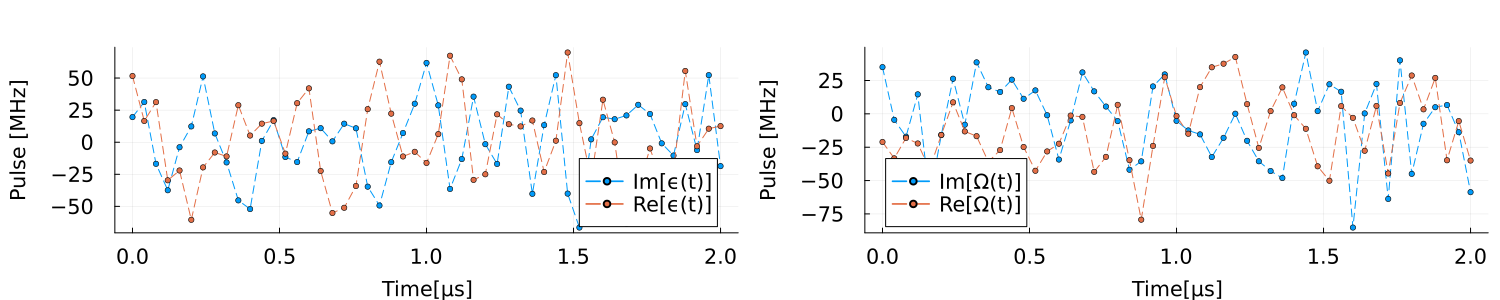

In [74]:
imaginary_part = plot([l for l in 0:T*d /50:T*d], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, layout=2, subplot=1, size=(1500,300), margin=10mm,xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /50:T*d], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*d /50:T*d], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, subplot=2, xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /50:T*d], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[μs]", ylabel="Pulse [MHz]", fmt = :PDF, subplot=2)
#savefig("../../plots/pulse_optimisation/x7photons_100timesteps_100ns_1dote-2Infidelity.pdf")

In [ ]:
g(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T / (50), x, RZ, ω_c, ω_q, 1, 1)

In [ ]:
res_reseding = Optim.optimize(g,optimised_coeffs[1:18] , LBFGS(), Optim.Options(show_trace=true, show_every=50))

In [ ]:
optimised_coeffs_2 = Optim.minimizer(res_reseding)

In [ ]:
coeffs_cavity = optimised_coeffs_2[1:9]
coeffs_qubit = optimised_coeffs_2[10:end]

In [ ]:
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T, t)

amps_c = [amplitude_c(l) for l in 0:T/50:T]
amps_q = [amplitude_q(l)  for l in 0:T/50:T]

In [ ]:
imaginary_part = plot([l for l in 0:T /50:T], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T /50:T], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T /50:T], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T /50:T], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)


In [ ]:
g(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T*2, T*2 / (200), x, RZ, ω_c, ω_q, 1, 1)

In [ ]:
res_reseding_2 = Optim.optimize(g,optimised_coeffs_2 , LBFGS(), Optim.Options(show_trace=true, show_every=10))

In [ ]:
optimised_coeffs_3 = Optim.minimizer(res_reseding_2)
res_reseding_2_bis = Optim.optimize(g,optimised_coeffs_3 , LBFGS(), Optim.Options(show_trace=true, show_every=10))

In [ ]:
coeffs_cavity = optimised_coeffs_3[1:7]
coeffs_qubit = optimised_coeffs_3[8:end]
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*2, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*2, t)

amps_c = [amplitude_c(l) for l in 0:T*2/(200):T*2]
amps_q = [amplitude_q(l)  for l in 0:T*2/(200):T*2]

In [ ]:
imaginary_part = plot([l for l in 0:T*2 / (200):T*2], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*2 / (200):T*2], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)

In [ ]:
optimised_coeffs_3_bis = Optim.minimizer(res_reseding_2_bis)
coeffs_cavity = optimised_coeffs_3_bis[1:7]
coeffs_qubit = optimised_coeffs_3_bis[8:end]
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*2, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*2, t)

amps_c = [amplitude_c(l) for l in 0:T*2/(200):T*2]
amps_q = [amplitude_q(l)  for l in 0:T*2/(200):T*2]

imaginary_part = plot([l for l in 0:T*2 / (200):T*2], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*2 / (200):T*2], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)

In [ ]:
optimised_coeffs_3_bis = Optim.minimizer(res_reseding_2_bis)